In [49]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import metrics, model_selection
import gensim.models.keyedvectors as word2vec
import gensim
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

In [2]:
#setting up google colab to use google drive for data_IO as well as to save model checkpoints
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


#### To test product to vec models

1.   Copy the models provided in models folder
2.   Copy path to the models folder to data_path variable

The idea behind the product to vec model is to find products that are bought together based on the different carts in the instacart data set. The idea is based upon the Omar Essam's bolg.



In [ ]:
model = word2vec.KeyedVectors.load_word2vec_format(data_path + "word2vec_model.bin", binary=True)

In [ ]:
pca = PCA(n_components=2)
pca.fit(model.wv.syn0)

In [27]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [51]:
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    """From Tensorflow's tutorial."""
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

def get_most_similar(word):
  suggestions = model.most_similar(positive=[word], topn=5)
  output = list()
  suggest = list()
  for i in suggestions:
      suggest.append(i[0])
  output += suggest
  output.append(word)
  embeds = []
  labels = []
  for item in output:
      embeds.append(model[item])
      labels.append(products.loc[int(item)]['product_name'])
  embeds = np.array(embeds)
  embeds = pca.fit_transform(embeds)
  plot_with_labels(embeds, labels)

In [15]:
data_path = "path_to_models_directory"

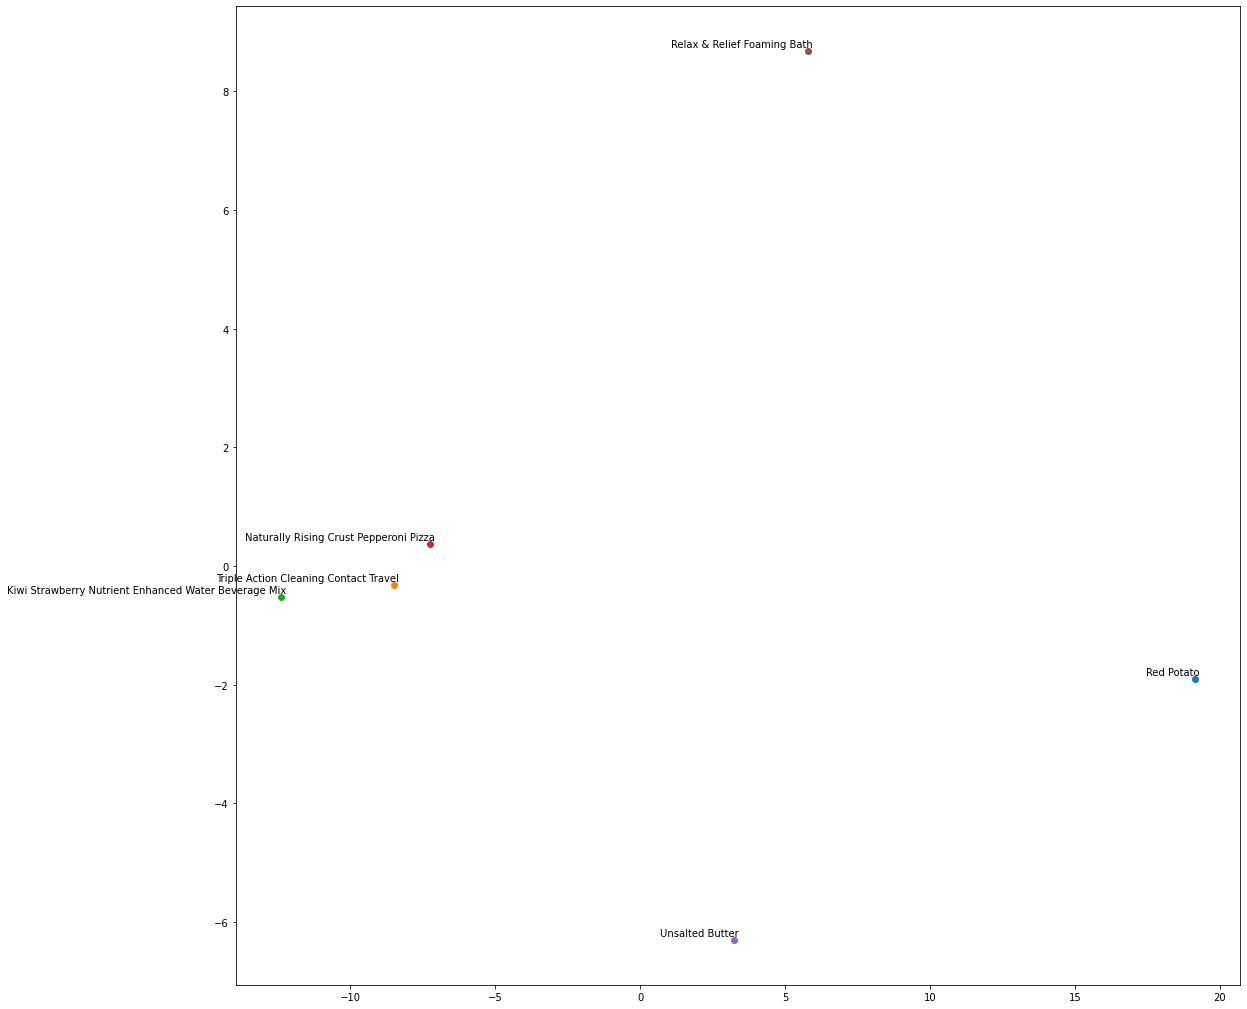

In [52]:
get_most_similar('13563')

### Training prod2vec model


In [ ]:
train_orders = pd.read_csv(data_path + "order_products__train.csv")
prior_orders = pd.read_csv(data_path +"order_products__prior.csv")
products = pd.read_csv(data_path + "products.csv").set_index('product_id')
train_orders["product_id"] = train_orders["product_id"].astype(str)
prior_orders["product_id"] = prior_orders["product_id"].astype(str)
train_products = train_orders.groupby("order_id").apply(lambda order: order['product_id'].tolist())
prior_products = prior_orders.groupby("order_id").apply(lambda order: order['product_id'].tolist())
sentences = prior_products.append(train_products)
longest = np.max(sentences.apply(len))
model = gensim.models.Word2Vec(sentences, size=100, window=longest, min_count=2, workers=4)
model.wv.save_word2vec_format(data_path+'word2vec_model.bin', binary=True)